<a href="https://colab.research.google.com/github/GadagiAmogh/portfolio/blob/master/Flower_Recognition_Dataset_Kaggle%2BTransfer_Learning%2BBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
import shutil
import numpy as np
import glob   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline


In [61]:
# ! pip install split-folders

In [62]:
# import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/Kaggle/flowers', output="/content/drive/MyDrive/Kaggle/FLOWERS", seed=1337, ratio=(.8, 0.1,0.1)) 

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (240, 199, 3)


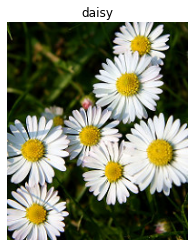

In [64]:
img = view_random_image(target_dir="/content/drive/MyDrive/Kaggle/FLOWERS/train/",
                        target_class="daisy")

In [96]:
image_size = 224
batch_size = 64
training_dir = "/content/drive/MyDrive/Kaggle/FLOWERS/train"
val_dir = "/content/drive/MyDrive/Kaggle/FLOWERS/val"
test_dir = "/content/drive/MyDrive/Kaggle/FLOWERS/test"

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_data = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical' )
valid_data = valid_data_gen.flow_from_directory(val_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 2870 images belonging to 5 classes.
Found 357 images belonging to 5 classes.


In [97]:
base_cnn_model = tf.keras.Sequential([
                                      Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
                                      Conv2D(10, 3, activation='relu'),
                                      MaxPooling2D((2,2)),
                                      Conv2D(10, 3, activation='relu'),
                                      Conv2D(10, 3, activation='relu'),
                                      MaxPooling2D((2,2)),
                                      Conv2D(10, 3, activation='relu'),
                                      Conv2D(10, 3, activation='relu'),
                                      MaxPooling2D((2,2)),
                                      Flatten(),
                                      Dense(5, activation='softmax')

])

In [98]:
base_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
base_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [101]:
hist1 = base_cnn_model.fit(train_data,epochs=15, validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/15
45/45 [==============================] - 20s 446ms/step - loss: 1.1418 - accuracy: 0.5645 - val_loss: 1.2219 - val_accuracy: 0.5154
Epoch 2/15
45/45 [==============================] - 20s 432ms/step - loss: 1.0450 - accuracy: 0.5979 - val_loss: 1.2913 - val_accuracy: 0.5154
Epoch 3/15
45/45 [==============================] - 19s 431ms/step - loss: 0.9184 - accuracy: 0.6474 - val_loss: 1.2110 - val_accuracy: 0.5294
Epoch 4/15
45/45 [==============================] - 19s 430ms/step - loss: 0.8179 - accuracy: 0.6976 - val_loss: 1.2398 - val_accuracy: 0.5266
Epoch 5/15
45/45 [==============================] - 19s 428ms/step - loss: 0.7277 - accuracy: 0.7265 - val_loss: 1.3693 - val_accuracy: 0.5322
Epoch 6/15
45/45 [==============================] - 19s 430ms/step - loss: 0.6199 - accuracy: 0.7735 - val_loss: 1.5195 - val_accuracy: 0.5154
Epoch 7/15
45/45 [==============================] - 20s 432ms/step - loss: 0.5118 - accuracy: 0.8185 - val_loss: 1.5778 - val_accuracy: 0.5322

In [83]:
def get_model():
  base_transfer_model = ResNet50(weights='imagenet', include_top=False)
  for layer in base_transfer_model.layers:
    layer.trainable = False

  base_transfer_model_output = base_transfer_model.output
  x = GlobalAveragePooling2D()(base_transfer_model_output)
  x= Dense(512, activation='relu')(x)
  x = Dense(5, activation='softmax')(x)
  model_resnet = Model(inputs=base_transfer_model.input, outputs = x)
  return model_resnet

In [84]:
model_res = get_model()

In [85]:
model_res.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [86]:
model_res.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_8[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [74]:
hist2= model_res.fit(train_data,epochs=5, steps_per_epoch = train_data.n//batch_size, validation_data=valid_data, validation_steps=valid_data.n//batch_size)

Epoch 1/5
44/44 [==============================] - 66s 597ms/step - loss: 0.6894 - accuracy: 0.7634 - val_loss: 0.4097 - val_accuracy: 0.8781
Epoch 2/5
44/44 [==============================] - 25s 567ms/step - loss: 0.3535 - accuracy: 0.8856 - val_loss: 0.3534 - val_accuracy: 0.8969
Epoch 3/5
44/44 [==============================] - 25s 562ms/step - loss: 0.2804 - accuracy: 0.9113 - val_loss: 0.2977 - val_accuracy: 0.9219
Epoch 4/5
44/44 [==============================] - 25s 561ms/step - loss: 0.2422 - accuracy: 0.9234 - val_loss: 0.2995 - val_accuracy: 0.9062
Epoch 5/5
44/44 [==============================] - 25s 562ms/step - loss: 0.2113 - accuracy: 0.9355 - val_loss: 0.2743 - val_accuracy: 0.9187


In [88]:
for layer in model_res.layers[:140]: layer.trainable = False
for layer in model_res.layers[140:]: layer.trainable = True
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_res.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = model_res.fit(train_data,epochs=14, steps_per_epoch = len(train_data),  validation_data=valid_data, validation_steps=len(valid_data))


Epoch 1/14
45/45 [==============================] - 43s 852ms/step - loss: 0.8203 - accuracy: 0.6983 - val_loss: 0.3168 - val_accuracy: 0.8992
Epoch 2/14
45/45 [==============================] - 34s 753ms/step - loss: 0.2562 - accuracy: 0.9230 - val_loss: 0.2512 - val_accuracy: 0.9216
Epoch 3/14
45/45 [==============================] - 34s 742ms/step - loss: 0.1522 - accuracy: 0.9599 - val_loss: 0.2229 - val_accuracy: 0.9244
Epoch 4/14
45/45 [==============================] - 34s 753ms/step - loss: 0.0998 - accuracy: 0.9798 - val_loss: 0.2118 - val_accuracy: 0.9328
Epoch 5/14
45/45 [==============================] - 34s 743ms/step - loss: 0.0688 - accuracy: 0.9913 - val_loss: 0.2041 - val_accuracy: 0.9328
Epoch 6/14
45/45 [==============================] - 34s 742ms/step - loss: 0.0508 - accuracy: 0.9955 - val_loss: 0.1994 - val_accuracy: 0.9356
Epoch 7/14
45/45 [==============================] - 34s 744ms/step - loss: 0.0351 - accuracy: 0.9990 - val_loss: 0.1984 - val_accuracy: 0.9412

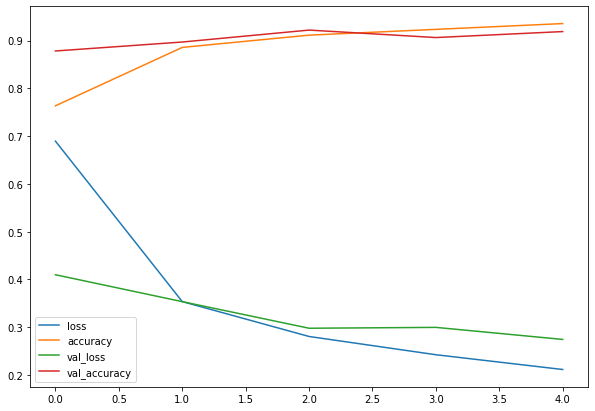

In [89]:
#Lets plot the training curve
import pandas as pd
pd.DataFrame(hist2.history).plot(figsize=(10,7));

In [94]:
#plot validation and training curve seperately
def plot_loss_curve(history):
  """
  Returns seperate loss curves for the metrics
  """
  train_loss = hist3.history['loss']
  val_loss = hist3.history['val_loss']

  accuracy = hist3.history['accuracy']
  val_accuracy = hist3.history['val_accuracy']

  epochs = range(len(hist3.history['loss']))

  #plot losses
  plt.plot(epochs, train_loss, label= 'Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label= 'Training accuracy')
  plt.plot(epochs, val_accuracy, label='Validation accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')


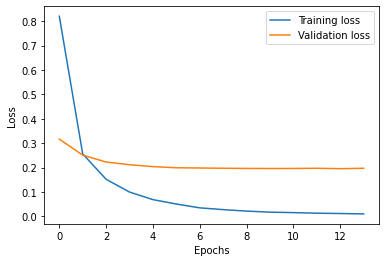

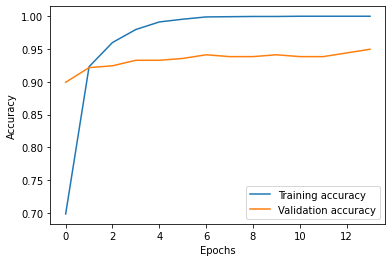

In [95]:
plot_loss_curve(hist3)